In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp


from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=8, cores=8,walltime='04:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=4)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [8]:
#ds =  xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_bandpassed_filtered.zarr')
grd = ut.load_grd(consolidated=False)[['XC', 'YC', 'Depth']]#.persist()
grd = grd.isel(j=slice(0,None,2),i=slice(0,None,2))
#ds['XC'] = grd.XC
#ds['YC'] = grd.YC

In [6]:
dsi = ds.SSU_rot_demodulated_real.isel(time=3000).isel(i=slice(0,None,2),j=slice(0,None,2))
dsi

<xarray.DataArray 'SSU_rot_demodulated_real' (face: 13, j: 2160, i: 2160)>
dask.array<getitem, shape=(13, 2160, 2160), dtype=float64, chunksize=(1, 25, 50), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
    time     datetime64[ns] 2012-03-19

In [7]:
dsi = dsi.persist()

In [9]:
dsi = dsi.assign_coords({'XC':grd.XC,'YC':grd.YC})
dsi = dsi.unify_chunks()

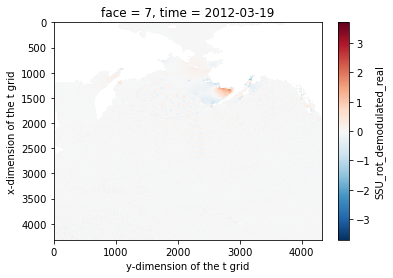

In [134]:
dsi.sel(face=7).plot(y='i',yincrease=False)

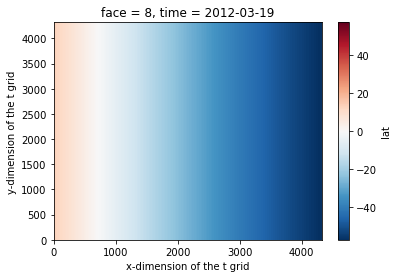

In [117]:
dsi.isel(face=8).lat.plot()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12, time = 2012-03-19'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

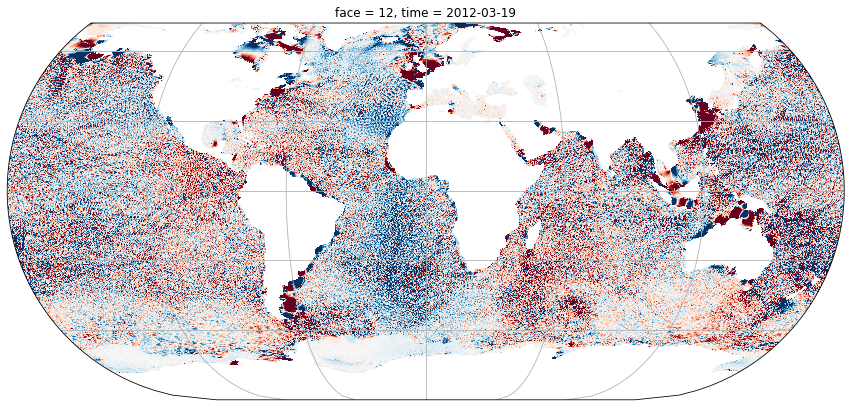

In [100]:
pl.plot_pretty(dsi,cmap='RdBu_r',vmax=0.1,vmin=-0.1,land=False)

In [16]:
#ds['Depth'] = grd.Depth
dsi['lon'] = 0*dsi.face+grd.XC
dsi['lat'] = 0*dsi.face+grd.YC

In [106]:
i = 8
print(dsi.isel(face=i).lon.max().compute(),dsi.isel(face=i).lon.min().compute())
print(dsi.isel(face=i).lat.max().compute(),dsi.isel(face=i).lat.min().compute())

<xarray.DataArray 'lon' ()>
array(179.96875)
Coordinates:
    face     int64 8
    time     datetime64[ns] 2012-03-19 <xarray.DataArray 'lon' ()>
array(-179.98957825)
Coordinates:
    face     int64 8
    time     datetime64[ns] 2012-03-19
<xarray.DataArray 'lat' ()>
array(13.72816563)
Coordinates:
    face     int64 8
    time     datetime64[ns] 2012-03-19 <xarray.DataArray 'lat' ()>
array(-56.98995209)
Coordinates:
    face     int64 8
    time     datetime64[ns] 2012-03-19


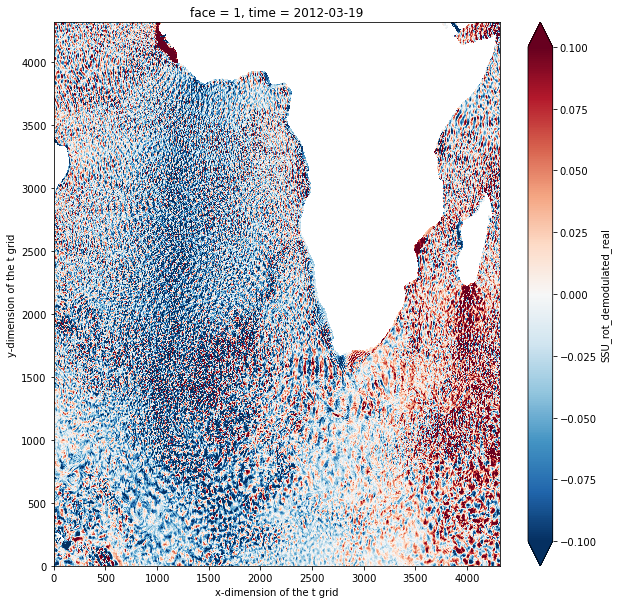

In [128]:
plt.figure(figsize=(10,10))
dsi.isel(face=1).plot(vmax=0.1,vmin=-0.1,cmap='RdBu_r')

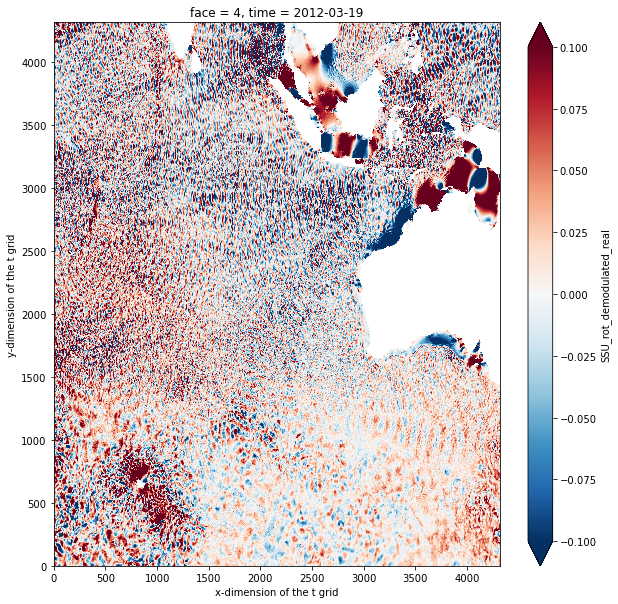

In [129]:
plt.figure(figsize=(10,10))
dsi.isel(face=4).plot(vmax=0.1,vmin=-0.1,cmap='RdBu_r')

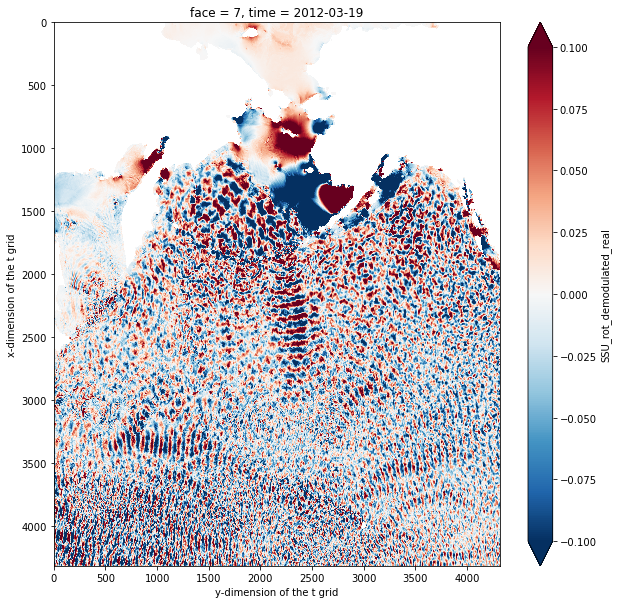

In [135]:

plt.figure(figsize=(10,10))
dsi.isel(face=7).plot(vmax=0.1,vmin=-0.1,cmap='RdBu_r',y='i',yincrease=False)

In [120]:
ds_GS = dsi.isel(face=10).where((dsi.isel(face=10).lon<-60) & (dsi.isel(face=10).lon>-90) &
                                (dsi.isel(face=10).lat<40) & (dsi.isel(face=10).lat>20),drop=True)
i_atl = 1
ds_atl = dsi.isel(face=i_atl).where((dsi.isel(face=i_atl).lon<-10) & (dsi.isel(face=i_atl).lon>-40) &
                                (dsi.isel(face=i_atl).lat<-10) & (dsi.isel(face=i_atl).lat>-30),drop=True)

i_eq = 8
ds_eq = dsi.isel(face=i_eq).where((dsi.isel(face=i_eq).lon<-120) & (dsi.isel(face=i_eq).lon>-150) &
                                (dsi.isel(face=i_eq).lat<10) & (dsi.isel(face=i_eq).lat>-10),drop=True)

In [121]:
ds_GS = ds_GS.persist()

In [122]:
ds_atl = ds_atl.persist()

In [123]:
ds_eq = ds_eq.persist()

In [109]:
ds_eq

<xarray.DataArray 'SSU_rot_demodulated_real' (j: 528, i: 521)>
dask.array<where, shape=(528, 521), dtype=float64, chunksize=(25, 50), chunktype=numpy.ndarray>
Coordinates:
    face     int64 8
  * i        (i) int64 200 202 204 206 208 210 ... 1230 1232 1234 1236 1238 1240
  * j        (j) int64 3264 3266 3268 3270 3272 ... 4310 4312 4314 4316 4318
    time     datetime64[ns] 2012-03-19
    YC       (j, i) float32 dask.array<chunksize=(528, 521), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(528, 521), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(528, 521), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(528, 521), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(528, 521), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(528, 521), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(528, 521), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(528, 521), meta=np.ndarray>

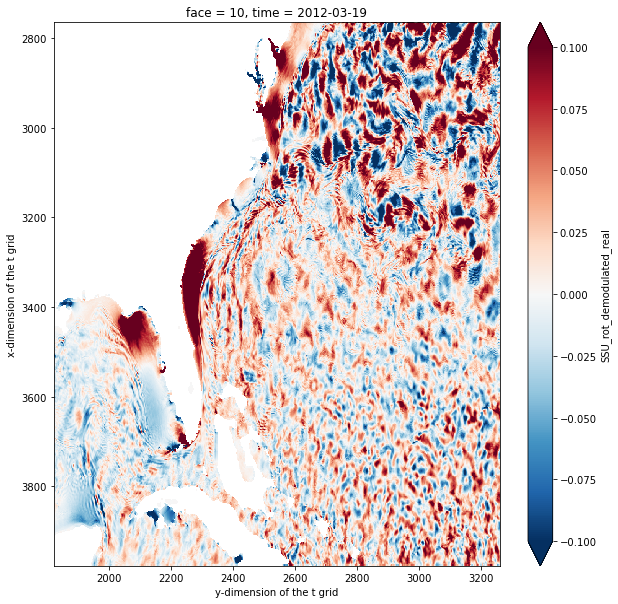

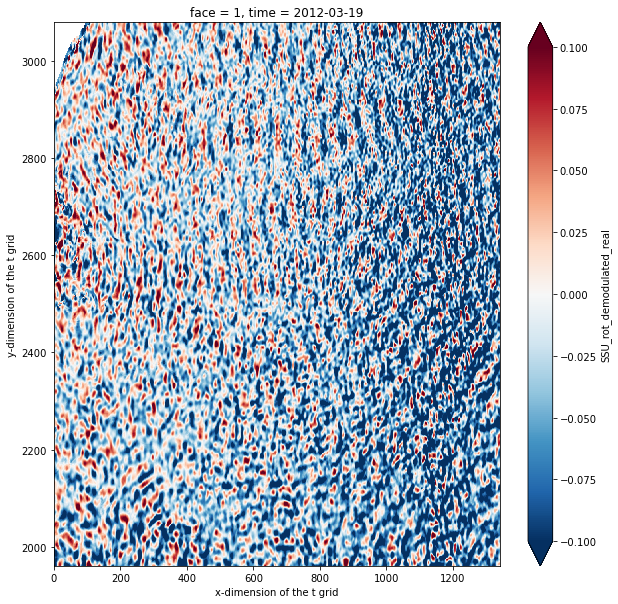

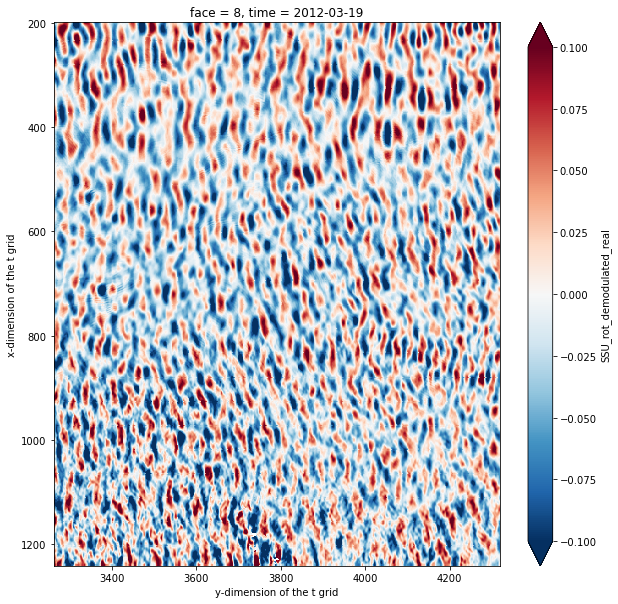

In [124]:
plt.figure(figsize=(10,10))
ds_GS.plot(y='i',yincrease=False,vmax=0.1)
plt.figure(figsize=(10,10))
ds_atl.plot(y='j',yincrease=True,vmax=0.1)
plt.figure(figsize=(10,10))
ds_eq.plot(y='i',yincrease=False,vmax=0.1)

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_zoom(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,**kwargs,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [136]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
